# 1 Programming Linear Regression

### Import Libraries 

In [76]:
import pandas as pd
from sklearn.compose import ColumnTransformer

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from sklearn import svm, metrics
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score

### Upload datasets

In [77]:
digits_dataset = pd.read_csv('digits.csv', header=None )
carseats_train = pd.read_csv('carseats_train.csv')
carseats_test  = pd.read_csv('carseats_test.csv')
carseats_train.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
1,13.91,110,110,0,408,68,Good,46,17,No,Yes
2,4.10,121,78,4,413,130,Bad,46,10,No,Yes
3,9.16,137,105,10,435,156,Good,72,14,Yes,Yes
4,7.22,135,93,2,67,119,Medium,34,11,Yes,Yes


# 1.2 Data preprocessing

### Binary variable encoding

In [78]:
# Convert 'Urban' and 'US' columns to binary variables (0/1)
carseats_train['Urban'] = carseats_train['Urban'].map({'No': 0, 'Yes': 1})
carseats_train['US'] = carseats_train['US'].map({'No': 0, 'Yes': 1})

carseats_test['Urban'] = carseats_test['Urban'].map({'No': 0, 'Yes': 1})
carseats_test['US'] = carseats_test['US'].map({'No': 0, 'Yes': 1})

### Categorical variable encoding

In [79]:
# one-hot encoding for 'ShelveLoc' (Categorical variable)
categorical_cols = ['ShelveLoc']
preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_cols)])

# one-hot encoding on categorical variables
train_categorical_encoded = preprocessor.fit_transform(carseats_train[categorical_cols])
test_categorical_encoded = preprocessor.transform(carseats_test[categorical_cols])

# DataFrames for the encoded categorical variables
train_categorical_df = pd.DataFrame(train_categorical_encoded, columns=preprocessor.get_feature_names_out(categorical_cols))
test_categorical_df = pd.DataFrame(test_categorical_encoded, columns=preprocessor.get_feature_names_out(categorical_cols))


### Feature standardization

In [80]:
# Separate continuous and categorical columns
continuous_cols = ['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education']
categorical_cols = ['ShelveLoc', 'Urban', 'US']

# Extract continuous variables from both train and test sets
train_continuous = carseats_train[continuous_cols]
test_continuous = carseats_test[continuous_cols]

# StandardScaler to standardize continuous features
scaler = StandardScaler()

# Standardize train and test sets
train_continuous_standardized = scaler.fit_transform(train_continuous)
test_continuous_standardized = scaler.transform(test_continuous)

# Replace original values in dataset with standardized values in the datasets
carseats_train[continuous_cols] = train_continuous_standardized
carseats_test[continuous_cols] = test_continuous_standardized

# Concatenate continuous and categorical variables
# Finalized dataset
X_train = pd.concat([pd.DataFrame(train_continuous_standardized, columns=continuous_cols), train_categorical_df], axis=1)
X_test = pd.concat([pd.DataFrame(test_continuous_standardized, columns=continuous_cols), test_categorical_df], axis=1)

In [81]:
# Target variable
y_train = carseats_train['Sales']
y_test = carseats_test['Sales']

# Final Dataset after one-hot encoding and scaling
X_train.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,cat__ShelveLoc_Bad,cat__ShelveLoc_Good,cat__ShelveLoc_Medium
0,-0.493529,1.117232,-0.379057,1.340795,-0.811724,0.102151,0.067511,0.0,0.0,1.0
1,-0.946049,1.468701,-0.983284,0.940667,-2.042773,-0.445699,1.224840,0.0,1.0,0.0
2,-0.234947,0.344000,-0.379057,0.975161,0.589126,-0.445699,-1.475594,1.0,0.0,0.0
3,0.799384,1.292966,0.527282,1.126933,1.692826,1.136979,0.067511,0.0,1.0,0.0
4,0.670093,0.871204,-0.681170,-1.411809,0.122176,-1.176165,-1.089818,0.0,0.0,1.0


# 1.3 Stochastic Gradient Descent

#### Suppose your training data consists of 1000 datapoints and you are using SGD to learn your model parameters. How many steps will the algorithm take in 2 epochs? 

Number of steps = Number of datapoints * Number of epochsNumber of steps = 1000 * 2
=2000

So, the algorithm will take 2000 steps in 2 epochs when using SGD with a training dataset of 1000 datapoints.

#### Write the stochastic gradient descent update rules for wj and b for lasso regression.

In report

# 1.5 Training


Test Loss for L1 Regularization (η=0.001, α=1): 8.56486
Test Loss for L1 Regularization (η=0.001, α=0.1): 1.26479
Test Loss for L1 Regularization (η=0.001, α=0.001): 1.07112
Test Loss for No Regularization (η=0.01, α=0): 1.09691
Test Loss for No Regularization (η=0.001, α=0): 1.07008


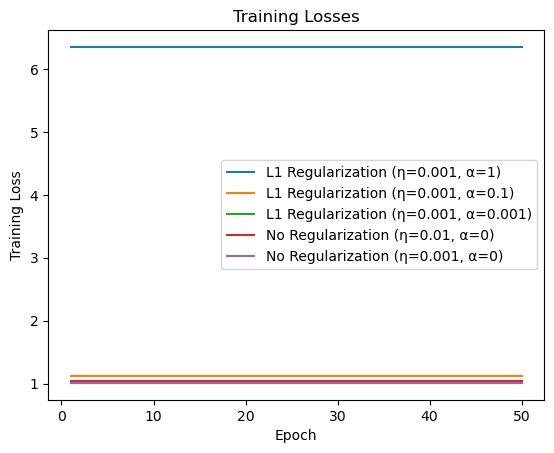

In [82]:
# Function to calculate squared loss
def calculate_loss(X, y, model):  
    y_pred = model.predict(X)
    loss = mean_squared_error(y, y_pred)
    return loss

def train_and_plot(X_train, y_train, X_test, y_test, epochs, alpha, learning_rate, label):
    losses = [] # For training losses
    model = make_pipeline(StandardScaler(), SGDRegressor(penalty='l1', max_iter=epochs, alpha=alpha, tol=1e-3, learning_rate='constant', eta0=learning_rate, random_state=42))
    model.named_steps['sgdregressor'].coef_ = np.zeros(X_train.shape[1] + 1) # model parameters to zero

    for epoch in range(epochs):
        model.fit(X_train, y_train)
        loss = calculate_loss(X_train, y_train, model)
        losses.append(loss)

    y_pred_test = model.predict(X_test)
    test_loss = mean_squared_error(y_test, y_pred_test)
    print(f'Test Loss for {label} (η={learning_rate}, α={alpha}): {test_loss:.5f}')
    plt.plot(range(1, epochs + 1), losses, label=f'{label} (η={learning_rate}, α={alpha})') # loss curve

# Given values
epochs = 50
alphas = [1, 0.1, 0.001]
learning_rates = [0.01, 0.001]

# Loop over alphas (where regularization is applied)
for alpha in alphas:
    # Plot for L1 regularization
    train_and_plot(X_train, y_train, X_test, y_test, epochs, alpha, 0.001, 'L1 Regularization')

# Additional loops for the new test cases (Where no regularization is applied)
for learning_rate in learning_rates:
    # Plot for no regularization
    train_and_plot(X_train, y_train, X_test, y_test, epochs, 0, learning_rate, 'No Regularization')

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.title('Training Losses')
plt.show()


# 2 Support Vector Machines

In [83]:
digits_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.0,7
1,0.0,0.0,0.0,0.20392,0.30196,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.039216,0.48235,0.22353,0.0,2
2,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.0,1
3,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.0,0
4,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.0,4


### Subset of Dataset

In [84]:
# Label column for digits dataset
label_column = digits_dataset.columns[-1]

# Subset with labels containing either digit 4 or 9
subset = digits_dataset[digits_dataset[label_column].astype(str).str.contains('4|9')]

# Save the subset and upload again
subset.to_csv("subset_dataset.csv", index=False)
subset_dataset = pd.read_csv('subset_dataset.csv' )
subset_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


### Split Dataset 

In [86]:
# Label column for subset dataset
label_column = subset_dataset.columns[-1]

# Separate features (X) and labels (y)
X = subset_dataset.iloc[:, :-1]  # All columns except the last one
y = subset_dataset[label_column]

# Split the dataset into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (714, 400)
X_test shape: (306, 400)
y_train shape: (714,)
y_test shape: (306,)


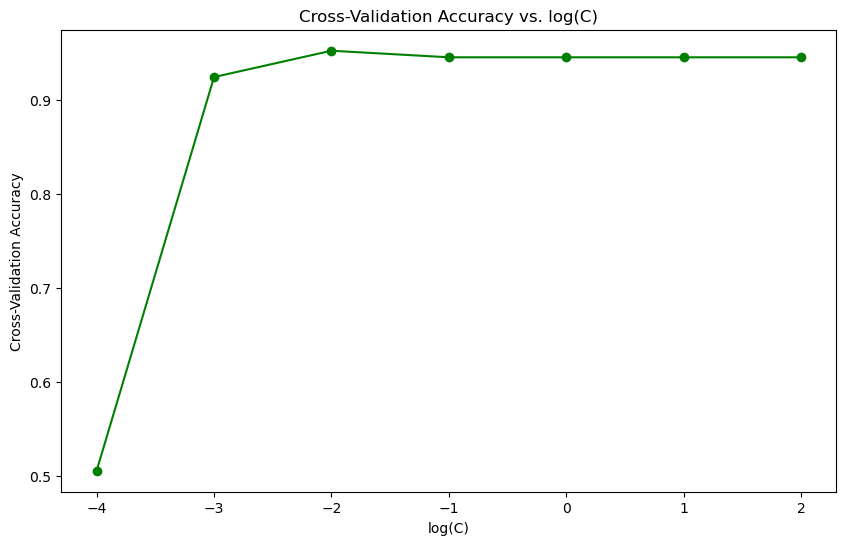

Best C value: 0.01
Highest Cross-Validation Accuracy: 0.9524

Training Metrics:
Accuracy: 0.9664
Precision: 0.9664
Recall: 0.9664

Test Metrics:
Accuracy: 0.9510
Precision: 0.9515
Recall: 0.9510


In [90]:
# SVM classifier with a linear kernel
svm_classifier = svm.SVC(kernel='linear')
C_values = [10**i for i in range(-4, 3)]

# cross-validation to find the best C value
grid = {'C': C_values}
grid_search = GridSearchCV(svm_classifier, grid, cv=2)
grid_search.fit(X_train, y_train)

# Best C value and corresponding cross-validation accuracy
best_C_Value = grid_search.best_params_['C']
best_accuracy = grid_search.best_score_

# Cross-validation accuracy plot
plt.figure(figsize=(10, 6))
plt.plot(np.log10(C_values), grid_search.cv_results_['mean_test_score'], marker='o', color='green')
plt.xlabel('log(C)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Accuracy vs. log(C)')
plt.show()

# Train an SVM classifier on the training data using the best C value
final_svm_classifier = svm.SVC(kernel='linear', C=best_C)
final_svm_classifier.fit(X_train, y_train)

# Predictions on the training and test data
y_train_pred = final_svm_classifier.predict(X_train)
y_test_pred = final_svm_classifier.predict(X_test)

# Performance evaluation on the training data
train_accuracy = metrics.accuracy_score(y_train, y_train_pred)
train_precision = metrics.precision_score(y_train, y_train_pred, average='weighted')
train_recall = metrics.recall_score(y_train, y_train_pred, average='weighted')

# Performance evaluation on the test data
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_precision = metrics.precision_score(y_test, y_test_pred, average='weighted')
test_recall = metrics.recall_score(y_test, y_test_pred, average='weighted')

# Results
print(f"Best C value: {best_C_Value}")
print(f"Highest Cross-Validation Accuracy: {best_accuracy:.4f}")
print("\nTraining Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")

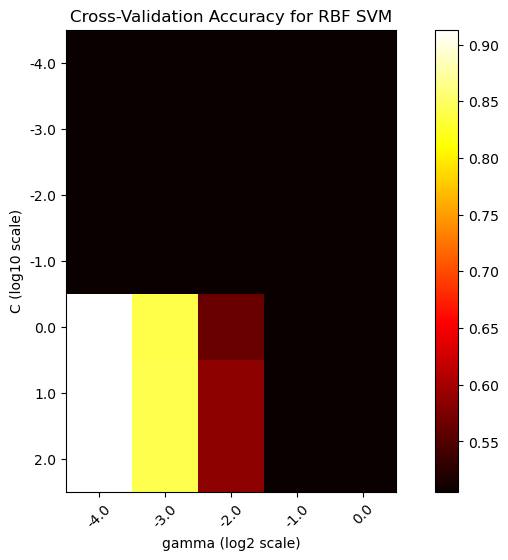

RBF SVM Results:
Best C value: 1
Best gamma value: 0.0625
Highest Cross-Validation Accuracy: 0.9132

Training Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Test Metrics:
Accuracy: 0.9510
Precision: 0.9520
Recall: 0.9510
F1 Score: 0.9510


In [20]:
# Define the range of C (same) and γ values to try
gamma_values = [2**i for i in range(-4, 1)]

# Create a parameter grid for GridSearchCV
grid = {'C': C_values, 'gamma': gamma_values}

# Create an SVM classifier with RBF kernel
rbf_svm_classifier = svm.SVC(kernel='rbf')

# Perform grid search with cross-validation to find the best C and γ values
grid_search_rbf = GridSearchCV(rbf_svm_classifier, grid, cv=2)
grid_search_rbf.fit(X_train, y_train)

# Get the best parameters and corresponding cross-validation accuracy
best_C_rbf = grid_search_rbf.best_params_['C']
best_gamma_rbf = grid_search_rbf.best_params_['gamma']
best_accuracy_rbf = grid_search_rbf.best_score_

# Plot cross-validation accuracy as a surface plot
scores = np.array(grid_search_rbf.cv_results_['mean_test_score']).reshape(len(C_values), len(gamma_values))
plt.figure(figsize=(10, 6))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma (log2 scale)')
plt.ylabel('C (log10 scale)')
plt.colorbar()
plt.xticks(np.arange(len(gamma_values)), np.log2(gamma_values), rotation=45)
plt.yticks(np.arange(len(C_values)), np.log10(C_values))
plt.title('Cross-Validation Accuracy for RBF SVM')
plt.show()

# Train an SVM classifier on the full training data using the best parameters
final_rbf_svm_classifier = svm.SVC(kernel='rbf', C=best_C_rbf, gamma=best_gamma_rbf)
final_rbf_svm_classifier.fit(X_train, y_train)

# Make predictions on the training and test data
y_train_pred_rbf = final_rbf_svm_classifier.predict(X_train)
y_test_pred_rbf = final_rbf_svm_classifier.predict(X_test)

# Evaluate performance on the training data
train_accuracy_rbf = metrics.accuracy_score(y_train, y_train_pred_rbf)
train_precision_rbf = precision_score(y_train, y_train_pred_rbf, average='weighted')
train_recall_rbf = recall_score(y_train, y_train_pred_rbf, average='weighted')
train_f1_rbf = f1_score(y_train, y_train_pred_rbf, average='weighted')

# Evaluate performance on the test data
test_accuracy_rbf = metrics.accuracy_score(y_test, y_test_pred_rbf)
test_precision_rbf = precision_score(y_test, y_test_pred_rbf, average='weighted')
test_recall_rbf = recall_score(y_test, y_test_pred_rbf, average='weighted')
test_f1_rbf = f1_score(y_test, y_test_pred_rbf, average='weighted')

# Print the results
print("RBF SVM Results:")
print(f"Best C value: {best_C_rbf}")
print(f"Best gamma value: {best_gamma_rbf}")
print(f"Highest Cross-Validation Accuracy: {best_accuracy_rbf:.4f}")

print("\nTraining Metrics:")
print(f"Accuracy: {train_accuracy_rbf:.4f}")
print(f"Precision: {train_precision_rbf:.4f}")
print(f"Recall: {train_recall_rbf:.4f}")
print(f"F1 Score: {train_f1_rbf:.4f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy_rbf:.4f}")
print(f"Precision: {test_precision_rbf:.4f}")
print(f"Recall: {test_recall_rbf:.4f}")
print(f"F1 Score: {test_f1_rbf:.4f}")